# Figure 11: Fake planet examples

This code is used to create **Figure 11** in the **Apples with Apples** paper (Bonse et al. in prep). The plot shows examples of residuals with and without fake planets. 

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import json


from applefy.detections import ContrastResults, collect_all_data_setup_configs, estimate_stellar_flux
from applefy.detections.preparation import calculate_planet_positions
from applefy.utils.general import center_subpixel
from applefy.utils.data_handling import open_fits, save_as_fits, load_adi_data
from applefy.utils.aperture_photometry import flux_ratio2mag, mag2flux_ratio, AperturePhotometryMode
from applefy.utils.data_handling import read_apples_with_apples_root, open_fits

## Data loading

<div style="text-align: justify">
We need to load example residuals (after PCA) which contain previously inserted artificial companions. We use again the results of the contrast grid in **Figure 7**.

In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.
</div>

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


First, we read in the residuals from their .fits files.

In [3]:
fake_planet_residual_path_1 = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_020_ID_0119b.fits")

fake_planet_residual_path_2 = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_050_ID_0115b.fits")

no_fake_planet_residual_path_1 = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_020_ID_0000.fits")

no_fake_planet_residual_path_2 = os.path.join(
    experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_050_ID_0000.fits")

planet_residual_1 = open_fits(fake_planet_residual_path_1)
planet_residual_2 = open_fits(fake_planet_residual_path_2)
no_planet_residual_1 = open_fits(no_fake_planet_residual_path_1)
no_planet_residual_2 = open_fits(no_fake_planet_residual_path_2)

In addition we need to know the position of the inserted fake planets which are given in the config files.

In [4]:
# Set the paths
fake_planet_config_path = os.path.join(
     experiment_root, 
    "70_results/detection_limits/Beta_Pic_non_stacked/configs_cgrid/exp_ID_0119b.json")

# Open the json files
with open(fake_planet_config_path) as json_file:
    fake_planet_config = json.load(json_file)

# Read out the planet positions
# The last two values in "planet_position" are the separation from the star and the position angle
planet_position = fake_planet_config["planet_position"][:2]

## Compute the Difference

We want to calculate the difference between the residual with and without fake planet. This difference is used to calculate the throughput in the analytic contrast curve.

In [5]:
fp_residual = no_planet_residual_1
tp_residual = planet_residual_1
difference_frame_1 = planet_residual_1 - no_planet_residual_1
difference_frame_2 = planet_residual_2 - no_planet_residual_2

## Create the Plot

A small function to plot the individual residual images.

In [6]:
# use the same color scale for all residuals
color_scale_max = np.max(tp_residual)
color_scale_min = np.min(tp_residual)

def create_residual_plot(
    axis_in,
    residual_image,
    show_planet_position,
    component_text,
    title_text):
    
    axis_in.imshow(
        residual_image, 
        vmin=color_scale_min,
        vmax=color_scale_max)
    
    axis_in.axes.get_yaxis().set_ticks([])
    axis_in.axes.get_xaxis().set_ticks([])

    axis_in.text(5, 70, component_text, 
                 color="white", fontsize=12)

    if show_planet_position:
        axis_in.scatter(
            planet_position[0], planet_position[1], 
            marker="o", facecolors='none',
            edgecolors='red', s=120, lw=1.5)

    axis_in.set_title(
        title_text,
        fontsize=14, 
        fontweight="bold", 
        y=1.01)

Create the actual plot.

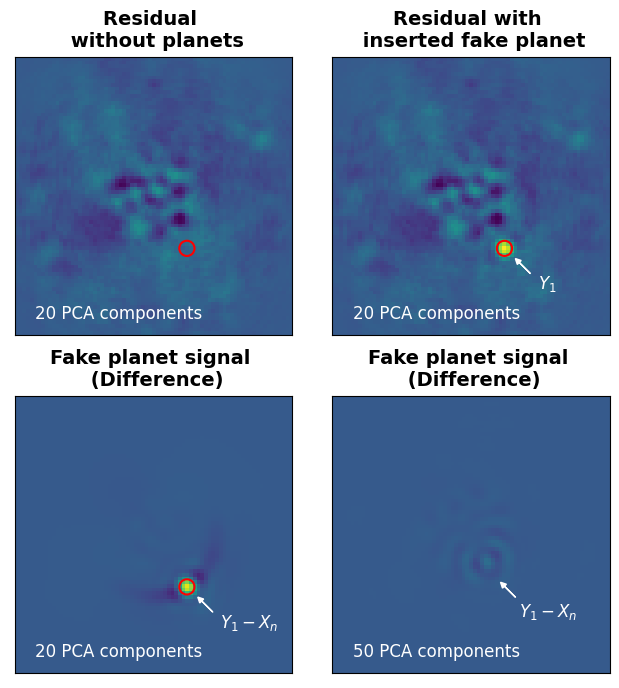

In [7]:
# 1.) Create the Plot Layout ------------------------------
fig = plt.figure(
    constrained_layout=False, 
    figsize=(8, 8))

gs0 = fig.add_gridspec(2, 2, width_ratios = [1, 1.0])
gs0.update(wspace=0.05, hspace=0.22)

# Residual Plots
res_without_planet_ax = fig.add_subplot(gs0[0, 0])
res_with_planet_ax = fig.add_subplot(gs0[0, 1])
res_difference_1 = fig.add_subplot(gs0[1, 0])
res_difference_2 = fig.add_subplot(gs0[1, 1])

# 2.) Plot the Residual without planet --------------------
create_residual_plot(
    res_without_planet_ax,
    fp_residual,
    show_planet_position=True,
    component_text="20 PCA components",
    title_text="Residual \n without planets")

# 3.) Plot the Residual with planet -----------------------
create_residual_plot(
    res_with_planet_ax,
    tp_residual,
    show_planet_position=True,
    component_text="20 PCA components",
    title_text="Residual with \n inserted fake planet")

res_with_planet_ax.text(55, 62, r"$Y_1$", 
                        color="white", fontsize=12)
res_with_planet_ax.arrow(53, 58, -3, -3, color="white",
                         head_length=1.5,head_width=1.5)

# 4.) Plot the Residual difference 1 ----------------------
create_residual_plot(
    res_difference_1,
    difference_frame_1,
    show_planet_position=True,
    component_text="20 PCA components",
    title_text="Fake planet signal \n (Difference)")

res_difference_1.text(55, 62, r"$Y_1 - X_n$", 
                      color="white", fontsize=12)
res_difference_1.arrow(53, 58, -3, -3, color="white",
                       head_length=1.5,head_width=1.5)

# 5.) Plot the Residual difference 2 ----------------------
create_residual_plot(
    res_difference_2,
    difference_frame_2,
    show_planet_position=False,
    component_text="50 PCA components",
    title_text="Fake planet signal \n (Difference)")

res_difference_2.text(50, 59, r"$Y_1 - X_n$",
                      color="white", fontsize=12)
res_difference_2.arrow(49, 54, -3, -3, color="white",
                       head_length=1.5,head_width=1.5)

# 6.) Save the Plot
fig.patch.set_facecolor('white')
plt.savefig("./11_Fake_planet_residuals.pdf", 
            bbox_inches='tight')